### Choose model and featureset to evaluate

In [19]:
%run "..\Model\DataHelpers.ipynb"

In [20]:
# Can be replaced with desired variant for different feature sets
GENE_FILE_VARIANT = FeatureVariant.RESEARCH_LOG # For values, see FeatureVariant.print_info()

MODEL_VARIANT_SVM = ModelVariant.SVM # For values, see ModelVariant.print_info()
MODEL_VARIANT_RF = ModelVariant.RF # For values, see ModelVariant.print_info()
MODEL_VARIANT_LG = ModelVariant.LG # For values, see ModelVariant.print_info()

FILE_PATH_LG_OUTPUT = f"../Data/model_output_{MODEL_VARIANT_LG}_{GENE_FILE_VARIANT}.csv"
FILE_PATH_RF_OUTPUT = f"../Data/model_output_{MODEL_VARIANT_RF}_{GENE_FILE_VARIANT}.csv"
FILE_PATH_SVM_OUTPUT = f"../Data/model_output_{MODEL_VARIANT_SVM}_{GENE_FILE_VARIANT}.csv"

FILE_PATH_LG_METRICS = f"../Data/model_metrics_{MODEL_VARIANT_LG}_{GENE_FILE_VARIANT}.csv"
FILE_PATH_RF_METRICS = f"../Data/model_metrics_{MODEL_VARIANT_RF}_{GENE_FILE_VARIANT}.csv"
FILE_PATH_SVM_METRICS = f"../Data/model_metrics_{MODEL_VARIANT_SVM}_{GENE_FILE_VARIANT}.csv"

print(FILE_PATH_LG_METRICS)
print(FILE_PATH_RF_METRICS)
print(FILE_PATH_SVM_METRICS)

print(FILE_PATH_LG_OUTPUT)
print(FILE_PATH_RF_OUTPUT)
print(FILE_PATH_SVM_OUTPUT)

../Data/model_metrics_logistic_regression_research_log.csv
../Data/model_metrics_random_forest_research_log.csv
../Data/model_metrics_svm_research_log.csv
../Data/model_output_logistic_regression_research_log.csv
../Data/model_output_random_forest_research_log.csv
../Data/model_output_svm_research_log.csv


### Get Evaluation Data

In [21]:
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Output files to load variants for
variants = {
    "Random Forest": FILE_PATH_RF_OUTPUT,
    "Support Vector Machine": FILE_PATH_SVM_OUTPUT,
    "Logistic Regression": FILE_PATH_LG_OUTPUT,
    # Adding more is possible but might need layout tweaks for readability
}
# Cross-validation metrics files to load variants for
variantMetrics = {
    "Random Forest": FILE_PATH_RF_METRICS,
    "Support Vector Machine": FILE_PATH_SVM_METRICS,
    "Logistic Regression": FILE_PATH_LG_METRICS,
    # Adding more is possible but might need layout tweaks for readability
}
baseColors = [] # To override the first couple of base colors, add them here (removed because unnecessary)
getColors = lambda n: ([ # Lambda to generate as many base colors as needed
    to_hex(plt.get_cmap('tab10')((i + len(baseColors)) % plt.get_cmap('tab10').N))
    for i in range(max(0, n - len(baseColors)))
])[:n]

# Definitions
evalPrecision = 'precision'
evalRecall = 'recall'
evalF1score = 'f1-score'

evalTargetN = 'nTNBC'
evalTarget = 'TNBC'

targetNames = [evalTargetN, evalTarget]
classLabels = ['Precision', 'Recall', 'F1-score']
models = variants.keys()

notTNBCData = {}
TNBCData = {}
accuracyData = {}
confusionMatrixes = {}

# Read evaluation data for all files
for model, file in variants.items():
    df = pd.read_csv(file)

    y_test = df['y_test']
    y_pred = df['y_pred']
    
    classification = classification_report(y_test, y_pred, output_dict=True, target_names=targetNames, zero_division=0)
    confusionMatrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    notTNBCData[model] = (classification[evalTargetN][evalPrecision]*100 , classification[evalTargetN][evalRecall]*100 , classification[evalTargetN][evalF1score]*100 )
    TNBCData[model] = (classification[evalTarget][evalPrecision]*100 , classification[evalTarget][evalRecall]*100 , classification[evalTarget][evalF1score]*100 )
    accuracyData[model] = accuracy*100
    confusionMatrixes[model] = confusionMatrix

TNBCData

{'Random Forest': (79.16666666666666, 82.6086956521739, 80.85106382978722),
 'Support Vector Machine': (73.07692307692307,
  82.6086956521739,
  77.55102040816327),
 'Logistic Regression': (76.92307692307693,
  86.95652173913044,
  81.63265306122449)}

### Plot the data to charts

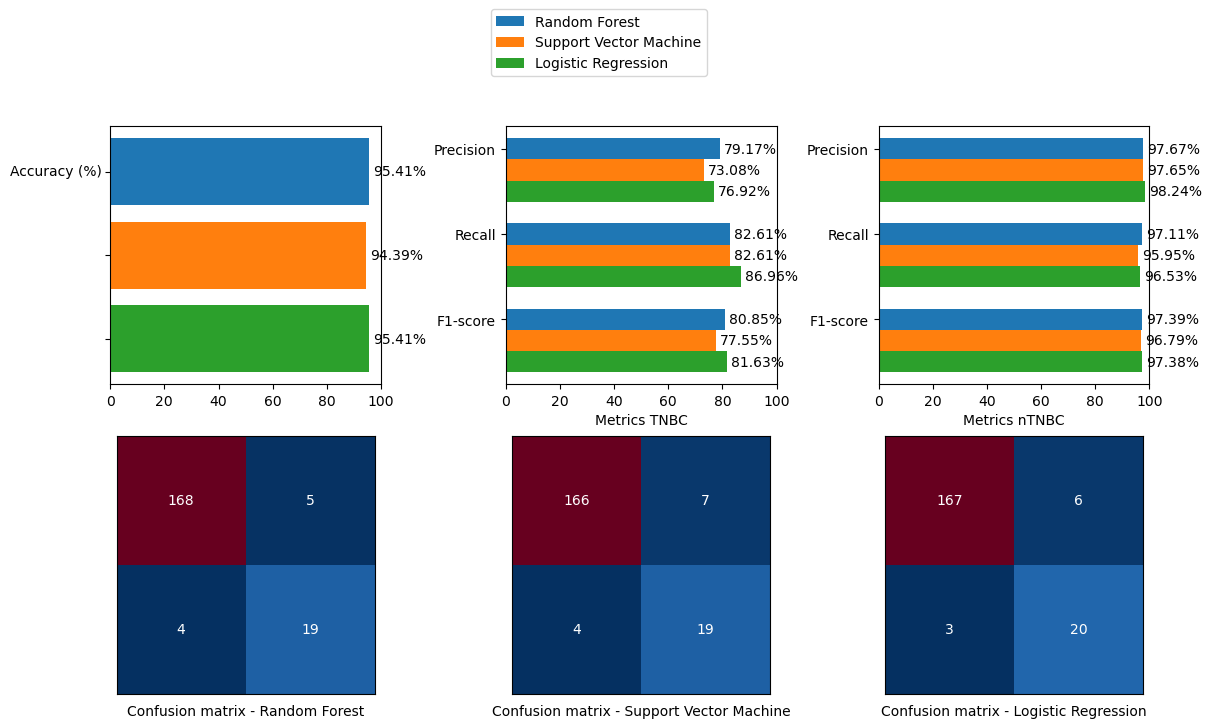

In [22]:
import numpy as np

# Define figure size (flexible to permit more than 3 figures at once, and to decide the number of columns to use)
ncols = 3 # Minimum three, for Accuracy, Metrics TNBC, Metrics nTNBC in the first row
nrows = ((len(accuracyData) + (ncols - 1)) // ncols) + 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained', figsize=[4*ncols, 3*nrows])
colors = getColors(len(accuracyData))
      
# == Accuracy
ax[0,0].set_xlim(0,100) 
rects = ax[0,0].barh(y=accuracyData.keys(), width=accuracyData.values(), color=colors)
ax[0,0].bar_label(rects, padding=3, fmt='%.2f%%')
ax[0,0].set_ylabel('Accuracy (%)', rotation=0, horizontalalignment='left')
ax[0,0].yaxis.set_label_coords(-0.37, 0.8)
ax[0,0].set_yticklabels('')
ax[0,0].invert_yaxis()

# == TNBC
width = 0.25
multiplier = 0
ax[0,1].set_xlim(0, 100)
y_pos = np.arange(3)
for attribute, measurement in TNBCData.items():
    offset = width * multiplier
    rectsTNBC = ax[0,1].barh(y_pos + offset, measurement, width, label=attribute, color=colors[multiplier])
    ax[0,1].bar_label(rectsTNBC, padding=3, fmt='%.2f%%')
    multiplier += 1

ax[0,1].set_yticks(y_pos)
ax[0,1].set_yticklabels(classLabels)
ax[0,1].invert_yaxis()
ax[0,1].set_xlabel('Metrics TNBC')

# == tNBC
multiplier = 0
ax[0,2].set_xlim(0, 100)
y_pos = np.arange(3)
for attribute, measurement in notTNBCData.items():
    offset = width * multiplier  
    rectsNTNBC = ax[0,2].barh(y_pos + offset, measurement, width, label=attribute)
    ax[0,2].bar_label(rectsNTNBC, padding=3, fmt='%.2f%%')
    multiplier += 1

ax[0,2].set_yticks(y_pos)
ax[0,2].set_yticklabels(classLabels)
ax[0,2].invert_yaxis()
ax[0,2].set_xlabel('Metrics nTNBC')

# == Confusion matrices
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

N = 0

for model in variants.keys():
    x = N % ncols
    y = (N // ncols) + 1
    ax[y,x].imshow(confusionMatrixes[model], cmap='RdBu_r')
    for i in range(2):
        for j in range(2):
            text = ax[y,x].text(j, i, confusionMatrixes[model][i, j], ha="center", va="center", color="white")
    
    ax[y,x].yaxis.set_visible(False)
    ax[y,x].set_xticklabels('')
    ax[y,x].set_xlabel(f"Confusion matrix - {model}")
    ax[y,x].tick_params(axis=u'both', which=u'both',length=0)
    N += 1

# Hide superfluous axes
for i in range(3, ncols):
    ax.flat[i].set_visible(False)
for i in range(ncols + len(accuracyData), nrows * ncols):
    ax.flat[i].set_visible(False)

fig.legend(handles=rects, labels=models, bbox_to_anchor=(0.09, 0.7, 0.5, 0.5))

chartsPartOne = plt.gcf()

plt.show()

### Plot the ROC Curve and Compute AUC Score

#### Get the ROC and AUC data

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

rocAucData = {}
fprTprData = {}

# Read evaluation data for all files
for model, file in variants.items():
    dataPath = '../Data'
    df = pd.read_csv(os.path.join(dataPath, file))
    y_test = df['y_test']
    y_prob = df['y_prob']

    fprTprData[model] = roc_curve(y_test, y_prob)
    rocAucData[model] = auc(fprTprData[model][0], fprTprData[model][1]) * 100

rocAucData

{'Random Forest': 98.50464940939935,
 'Support Vector Machine': 98.07740638351345,
 'Logistic Regression': 98.16536818296055}

#### Plot the data to charts

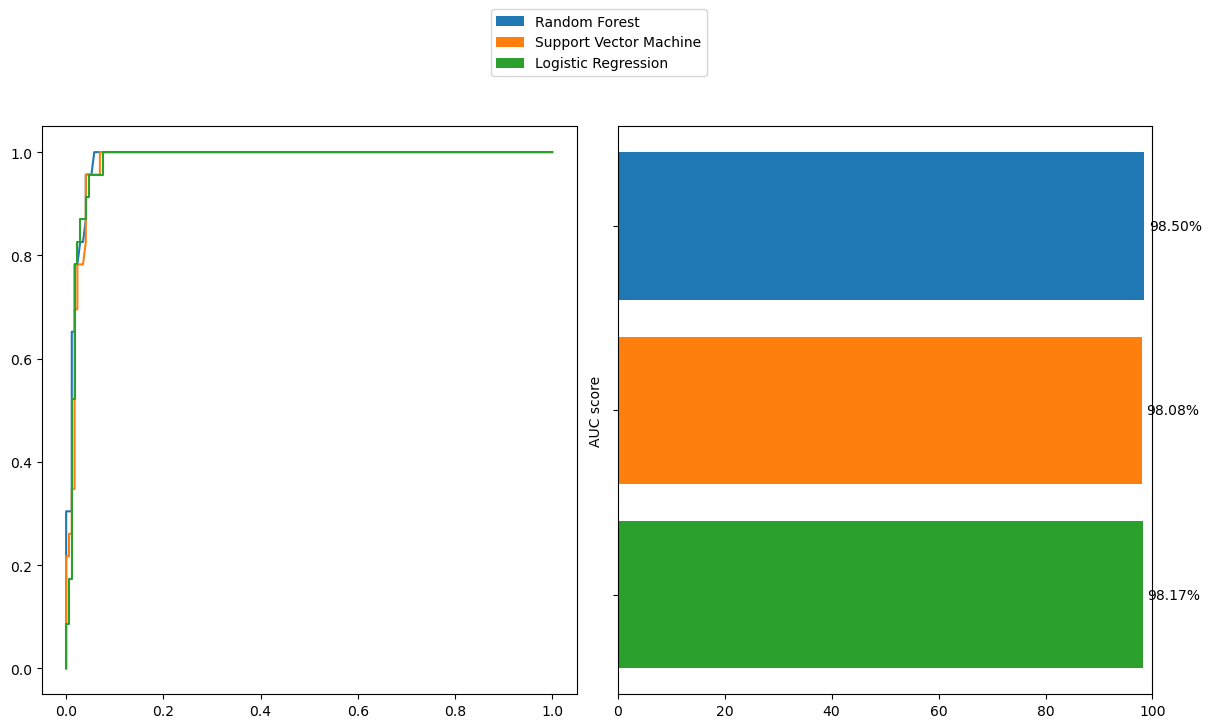

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, layout='constrained', figsize=[12,6])

## Computing ROC curve [978-14-49-36988-0]


for model, fprTpr in fprTprData.items():
    ax[0].plot(fprTpr[0], fprTpr[1], label=model)

rects = ax[1].barh(y=rocAucData.keys(), width=rocAucData.values(), color=colors)
ax[1].set_xlim(0, 100)
ax[1].bar_label(rects, padding=3, fmt='%.2f%%')
ax[1].set_ylabel('AUC score')
ax[1].set_yticklabels('')
ax[1].invert_yaxis()

fig.legend(handles=rects, labels=models, bbox_to_anchor=(0.09, 0.7, 0.5, 0.5))

chartsPartTwo = plt.gcf()

plt.show()

### Cross Model Validation

#### Get 5-Fold Cross Validation data

In [25]:
# Note: The actual N-Fold Cross-validation was performed by the model itself (see Model folder). Additional metrics besides accuracy were exported as well

nFoldData = {}

for model, file in variantMetrics.items():
    dataPath = '../Data'
    df = pd.read_csv(os.path.join(dataPath, file))
    cs_scores = df['accuracy']
    nFoldData[model] = cs_scores.mean() * 100

nFoldData

{'Random Forest': 93.94688644688645,
 'Support Vector Machine': 94.20242455956743,
 'Logistic Regression': 93.68916797488227}

#### Plot data to charts

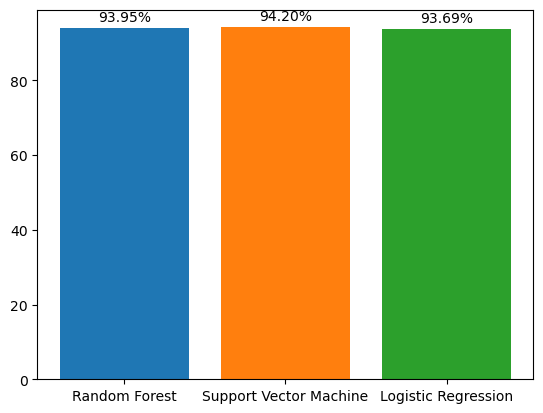

In [26]:
fig, ax = plt.subplots()

rects = ax.bar(nFoldData.keys(), nFoldData.values(), label=nFoldData.keys(), color=getColors(len(nFoldData)))
ax.bar_label(rects, padding=3, fmt='%.2f%%')

plt.show()
